<a href="https://colab.research.google.com/github/peeush-agarwal/week-based-learning/blob/master/Deep-Learning/horses_or_humans_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network to classify Horses or Humans from dataset

## Required libraries

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets

## Load dataset

In [3]:
# ! wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
# ! wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
print(os.curdir)
%cd /content
! mkdir Data
%cd Data
! mkdir horses-or-humans-dataset
%cd horses-or-humans-dataset
! mkdir horse-or-human
%cd horse-or-human
! mkdir train
! mkdir validation
%cd /content
! unzip horse-or-human.zip -d /content/Data/horses-or-humans-dataset/horse-or-human/train
! unzip validation-horse-or-human.zip -d /content/Data/horses-or-humans-dataset/horse-or-human/validation

.
/content
/content/Data
/content/Data/horses-or-humans-dataset
/content/Data/horses-or-humans-dataset/horse-or-human
/content
Archive:  horse-or-human.zip
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/horses/horse01-0.png  
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/horses/horse01-1.png  
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/horses/horse01-2.png  
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/horses/horse01-3.png  
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/horses/horse01-4.png  
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/horses/horse01-5.png  
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/horses/horse01-6.png  
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/horses/horse01-7.png  
  inflating: /content/Data/horses-or-humans-dataset/horse-or-human/train/hor

In [0]:
dataset_base_path = r'Data/horses-or-humans-dataset/horse-or-human'

dataset_train_path = dataset_base_path + '/train'
dataset_valid_path = dataset_base_path + '/validation'

train_horses_path = dataset_train_path + '/horses'
train_humans_path = dataset_train_path + '/humans'

valid_horses_path = dataset_valid_path + '/horses'
valid_humans_path = dataset_valid_path + '/humans'

batch_size = 10

In [0]:
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder(dataset_train_path, transform=transformations)
valid_dataset = datasets.ImageFolder(dataset_valid_path, transform=transformations)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

unloader = transforms.ToPILImage()

## Plot sample images

In [6]:
train_iter = iter(trainloader)
images, labels = train_iter.next()
print(type(images))
print(images.shape)
print(type(labels))
print(labels.shape)

images = images.numpy()
print(images.shape)

<class 'torch.Tensor'>
torch.Size([10, 3, 300, 300])
<class 'torch.Tensor'>
torch.Size([10])
(10, 3, 300, 300)


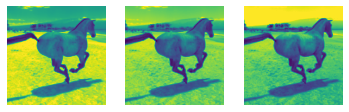

In [7]:
# Plot an image for all 3 channels separately
img_0_0 = images[0, 0, :, :] # First image, 1st channel, all pixels
img_0_1 = images[0, 1, :, :] # First image, 2nd channel, all pixels
img_0_2 = images[0, 2, :, :] # First image, 3rd channel, all pixels

plt.subplot(131)
plt.imshow(img_0_0)
plt.axis('off')

plt.subplot(132)
plt.imshow(img_0_1)
plt.axis('off')

plt.subplot(133)
plt.imshow(img_0_2)
plt.axis('off')

plt.show()

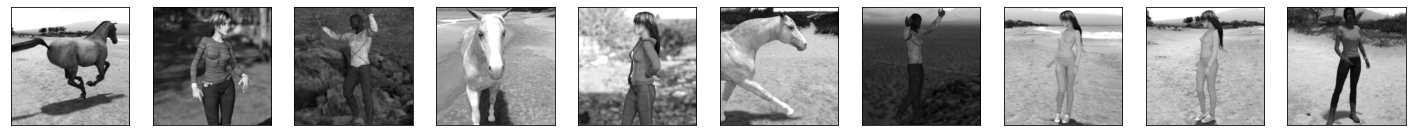

In [8]:
# plot the images in the batch
images_2 = images[:, 2, :, :]
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images_2[idx]), 'gray')

## Design Neural network

Points to remember:

+ Input neurons of next layer => $(W - F + 2*P)/S + 1$ where, 
  + W = input neurons
  + F = Filter or Kernel size
  + P = Padding
  + S = Stride

In [0]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def check_if_cuda_working():
    cuda = torch.device('cuda')     # Default CUDA device

    x = torch.tensor([1., 2.], device=cuda)
    y = torch.tensor([1., 2.], device=cuda)

    try:
        print(x + y)
        return True
    except:
        return False

In [13]:
device = get_device()

if torch.cuda.is_available():
    print(f'Cuda version: {torch.version.cuda}')
    print(f'Cuda device name: {torch.cuda.get_device_name(0)}')
    if not check_if_cuda_working():
        print('Cuda op not working, switching to cpu device')
        device = torch.device('cpu')

print(f'Device: {device}')

Cuda version: 10.1
Cuda device name: Tesla P100-PCIE-16GB
tensor([2., 4.], device='cuda:0')
Device: cuda


In [0]:
device = get_device()

In [0]:
class HumansOrHorses(nn.Module):
    def __init__(self):
        super(HumansOrHorses, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv4 = nn.Conv2d(16, 32, 3)

        self.pool = nn.MaxPool2d(2, 2)

        # 32 * 8 * 8 => 2048
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # 3 x 300 x 300 => 4 x 298 x 298
        x = F.relu(self.conv2(x)) # 4 x 298 x 298 => 8 x 296 x 296
        x = self.pool(x) # 8 x 296 x 296 => 8 x 148 x 148
        x = self.pool(x) # 8 x 148 x 148 => 8 x 74 x 74
        x = F.relu(self.conv3(x)) # 8 x 74 x 74 => 16 x 72 x 72
        x = self.pool(x) # 16 x 72 x 72 => 16 x 36 x 36
        x = self.pool(x) # 16 x 36 x 36 => 16 x 18 x 18
        x = F.relu(self.conv4(x)) # 16 x 18 x 18 => 32 x 16 x 16
        x = self.pool(x) # 32 x 16 x 16 => 32 x 8 x 8

        # flatten image input
        x = x.view(-1, 32 * 8 * 8) # 32 * 8 * 8  => 2048
        # add 1st linear layer, with relu activation function
        x = F.relu(self.fc1(x)) # 2048 => 512
        # add 2nd linear layer
        x = self.fc2(x) # 512 => 2
        return x

In [0]:
net = HumansOrHorses().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr = 0.01)

In [43]:
%%time
print('training started\n')

epochs = 25
loss_list = []
accuracy_list = []
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, label = data[0].to(device), data[1].to(device)
        #labels = labels.unsqueeze(1)
        #labels = labels.type(torch.FloatTensor)
        
        optimizer.zero_grad()

        output = net(inputs)
          
        # Get predictions from the maximum value
        predicted = torch.max(output.data, 1)[1]
        
        # Total number of labels
        total += len(label)

        # Total correct predictions
        correct += (predicted == label).sum()

        output = output.type(torch.FloatTensor).to(device)
        loss = criterion(output, label)

        loss.backward() # updates weights
        optimizer.step() # Reduces loss function. Helps in Backward propogation

        running_loss += loss.item()
    loss_per_item = running_loss/len(trainloader)
    loss_list.append(loss_per_item)
    accuracy = 100 * correct / float(total)
    accuracy_list.append(accuracy)
    print('epoch:{0}, loss:{1}, accuracy:{2}'.format(epoch+1, loss_per_item, accuracy))

print('\n training finished')

training started

epoch:1, loss:0.6904154871273966, accuracy:59.10418701171875
epoch:2, loss:0.6799488848852879, accuracy:67.5754623413086
epoch:3, loss:0.6094921393301881, accuracy:75.36514282226562
epoch:4, loss:0.49711648266292313, accuracy:76.33885192871094
epoch:5, loss:0.4348801410603292, accuracy:80.42843627929688
epoch:6, loss:0.35113433661680776, accuracy:84.32327270507812
epoch:7, loss:0.2671874555786258, accuracy:90.16553497314453
epoch:8, loss:0.19490161431428876, accuracy:92.30769348144531
epoch:9, loss:0.170826615582591, accuracy:93.08666229248047
epoch:10, loss:0.12672790820773655, accuracy:95.0340805053711
epoch:11, loss:0.08958111953519249, accuracy:96.98149871826172
epoch:12, loss:0.07336641382312999, accuracy:97.46835327148438
epoch:13, loss:0.05447175100816468, accuracy:98.14995574951172
epoch:14, loss:0.06818620324246721, accuracy:97.95521545410156
epoch:15, loss:0.033293515011765404, accuracy:98.92892456054688
epoch:16, loss:0.018769331582007, accuracy:99.41577911

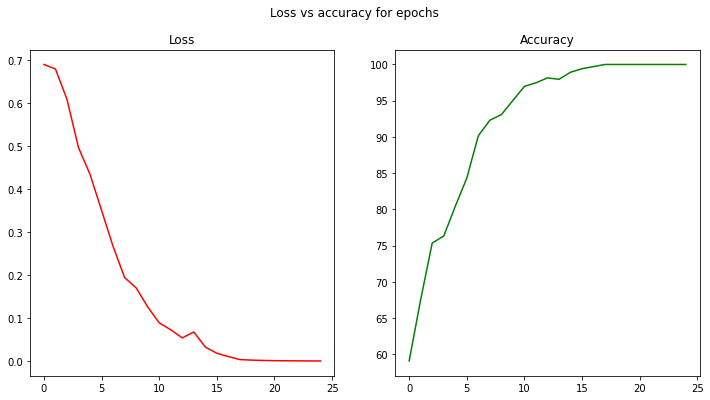

In [44]:
# Plot training loss graph
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(range(epochs), loss_list, 'r-')
plt.title('Loss')
plt.subplot(122)
plt.plot(range(epochs), accuracy_list, 'g-')
plt.title('Accuracy')
plt.suptitle('Loss vs accuracy for epochs')
plt.show()

In [45]:
# Calculate Accuracy         
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        inputs, label = data[0].to(device), data[1].to(device)
        output = net(inputs)
          
        # Get predictions from the maximum value
        predicted = torch.max(output.data, 1)[1]
        # Total number of labels
        total += len(label)
        # Total correct predictions
        correct += (predicted == label).sum()

        loss = criterion(output, label)
        running_loss += loss.item()

    print('Validation data:')
    print("- Loss : {}".format(running_loss/len(validloader)))
    print("- Accuracy : {}".format(100 * correct / float(total)))

Validation data:
- Loss : 1.0384145977187142
- Accuracy : 89.84375
